In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from astropy.constants import G
import astropy.units as u
import seaborn as sns

In [2]:
def search_closest_upper(value, array):
    diff = array - value
    return np.where(diff >= 0)[0][0]

In [3]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
apx_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()

In [3]:
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
apx_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
#apx_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final.npy', allow_pickle=True).tolist()

In [4]:
time_list = np.array([ray_tree['0'][key]['time'] for key in ray_tree['0'].keys()])
idx_list = np.array([int(key) for key in ray_tree['0'].keys()])

In [5]:
ray_halo_wstars = {}
apx_halo_wstars = {}

In [7]:
idx = '170'

ray_halo_wstars_pos = np.empty(shape=(0,3))
ray_halo_wstars_rvir = np.array([])
ray_halo_wstars_branch = np.array([])
#ray_halo_wstars_dmmass = np.empty(shape=(0,1))

for key, vals in ray_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        ray_halo_wstars[key] = vals[idx]
        ray_halo_wstars_pos = np.vstack((ray_halo_wstars_pos, vals[idx]['coor']))
        ray_halo_wstars_rvir = np.append(ray_halo_wstars_rvir, vals[idx]['Rvir'])
        ray_halo_wstars_branch = np.append(ray_halo_wstars_branch, key)
        
for key, vals in apx_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        apx_halo_wstars[key] = vals[idx]

In [8]:
#Locate the overlapping halos. 
#For these halos, the stellar mass from the Thinh_structure file can be double counted. Therefore, we need to uniquely assign stars to each halo rather than loading the whole yt region.
overlap_pair = []
for i in range(len(ray_halo_wstars_branch)):
    for j in range(len(ray_halo_wstars_branch)):
        if (i == j) or sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]) in overlap_pair:
            continue
        else:
            if np.linalg.norm(ray_halo_wstars_pos[i] - ray_halo_wstars_pos[j]) < (ray_halo_wstars_rvir[i] + ray_halo_wstars_rvir[j]): #overlapping condition
                overlap_pair.append(sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]))

overlap_group = []
for pair in overlap_pair:
    if pair == overlap_pair[0]:
        group = pair
    else:
        if (pair[0] in group) or (pair[1] in group):
            group = list(set(group + pair))
        else:
            overlap_group.append(group)
            group = pair

In [9]:
#These are the groups of halos that need to be disentangled in terms of stellar mass
overlap_group

[['0_20', '0_21', '0', '0_16', '0_18', '0_19', '0_4', '0_2'],
 ['1', '1_14', '1_10'],
 ['3_1', '3', '3_7'],
 ['5', '5_1']]

In [76]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [79]:
group_test = np.array(overlap_group[0])
group_velcom = np.array([ray_rawtree[group_i][int(idx)]['Vel_Com'] for group_i in group_test])
#convert the unit of halo velocity from code_length/s to km/s
ds = yt.load(ray_pfs[int(idx)])
group_velcom = (group_velcom*ds.units.code_length/ds.units.s).to('km/s').v
group_starID = {}
allstars = []
for halo in group_test:
    halo_center = ray_tree[halo][idx]['coor']
    halo_radius = ray_tree[halo][idx]['Rvir']
    boolean = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_radius
    group_starID[halo] = ray_ID_all[boolean].astype(int)
    allstars = list(set(allstars + list(ray_ID_all[boolean].astype(int))))
allstars = np.array(group_allstars)

yt : [INFO     ] 2024-12-10 10:23:52,751 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2024-12-10 10:23:52,752 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-10 10:23:52,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-10 10:23:52,762 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-10 10:23:52,765 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-10 10:23:52,768 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2024-12-10 10:23:52,770 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-10 10:23:52,773 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: hubble_constant           = 0.679


In [32]:
group_starID

{'0_20': array([65363538, 65364102, 65364638, 65364670, 65364748]),
 '0_21': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
        65734358, 65734359, 65734360, 65734362, 65734363, 65734364,
        65734366]),
 '0': array([65363541, 65363542, 65364086, ..., 65665931, 65665937, 65724384]),
 '0_16': array([65363537, 65363546, 65363851, ..., 65665931, 65665937, 65724384]),
 '0_18': array([65363541, 65363542, 65364086, 65364088, 65364194, 65364698,
        65364664, 65364679, 65364681, 65614185, 65614414, 65617205,
        65659343, 65363652, 65363539, 65363540, 65363665, 65363673,
        65363674, 65363767, 65363773]),
 '0_19': array([65363541, 65363542, 65364086, 65364113, 65364693, 65364695,
        65364700, 65363652, 65363826, 65363539, 65363540, 65363665,
        65363673, 65363683, 65363767, 65363773, 65363831, 65364106]),
 '0_4': array([65364088, 65364194, 65364127, 65364129]),
 '0_2': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
       

In [33]:
allstars

array([65732608, 65658881, 65658882, ..., 65363965, 65724414, 65732607])

In [46]:
count_list = {}
for ID in allstars:
    count = 0
    branch_overlap = []
    for branch in group_starID.keys():
        if ID in group_starID[branch]:
            count += 1
            branch_overlap.append(branch)
    if count > 1:
        count_list[ID] = [count, branch_overlap]

In [85]:
ray_vel_all[ray_ID_all == 65732608]

array([[-65.81759841,  12.10400267, 120.21314368]])

In [90]:
ray_rawtree['0'][171]

{'NumParts': 10324,
 'Halo_Mass': 7628372984.201647,
 'Halo_Radius': 0.003219896406693052,
 'cden': 202.11934833096655,
 'r100': 0.0038463181360783145,
 'r150': 0.0036909953190874156,
 'r200': 0.003237456954225626,
 'r250': 0.0028894798550874417,
 'r300': 0.0026477752928777674,
 'r500': 0.0020518783497319,
 'r700': 0.001687430599046631,
 'Halo_Center': array([0.49444511, 0.50351903, 0.51216658]),
 'Vel_Com': array([-7.90055792e-19, -4.80827245e-20,  1.03378648e-19])}

In [86]:
count_list[65732608]

[2, ['0', '0_16']]

In [88]:
group_velcom[group_test == '0']

array([[-35.6028203 ,  -4.23333669,  10.90924301]])

In [89]:
group_velcom[group_test == '0_16']

array([[  8.91740217, -44.69326534,  60.8857723 ]])

In [65]:
group_test

['0_20', '0_21', '0_4', '0_16', '0', '0_18', '0_19', '0_2']

In [14]:
ray_pos_all.shape

(30056, 3)

In [17]:
ray_halo_wstars_pos

array([[0.49420246, 0.50316925, 0.51266823],
       [0.49296721, 0.50155015, 0.51324955],
       [0.47673882, 0.50389487, 0.5022506 ],
       [0.48908694, 0.50969391, 0.50063493],
       [0.50191681, 0.51200992, 0.53478709],
       [0.50191068, 0.51098171, 0.53401179],
       [0.50015472, 0.49932791, 0.512181  ],
       [0.48527808, 0.4967556 , 0.51121502],
       [0.50025661, 0.50790924, 0.53018027],
       [0.49264434, 0.51777617, 0.49249299],
       [0.48658425, 0.52111066, 0.52580045],
       [0.5022803 , 0.51522828, 0.53829083],
       [0.50312778, 0.51599952, 0.53952004]])

In [21]:
ray_halo_wstars.keys()

dict_keys(['0', '0_2', '1', '3', '4', '4_0', '5', '6', '8', '9', '18', '20', '69'])

In [22]:
ray_halo_wstars['0_2']

{'tree_loc': '0_2',
 'coor': array([0.49296721, 0.50155015, 0.51324955]),
 'Rvir': 0.0014047493591527603,
 'redshift': 10.886019680253,
 'time': 0.42308436376385633,
 'gas_mass': 170519124.77518892,
 'gas_mass_frac': 0.12780071866170767,
 'h2_mass': 5220394.575481022,
 'h2_fraction': 0.030614715987802243,
 'dm_mass': 1162249229.1687708,
 'pop2_mass': 1489589.9787338013,
 'pop3_mass': 5.17818883535532,
 'star_mass': 1489595.1569226366,
 'metal_mass': 14570.536272090665,
 'metallicity': 8.544810613648377e-05,
 'sfr': 0.0,
 'total_mass': 1334257949.1008823}

We need to assign each star to a unique halo. This can be done by tracking back the star's position when it first forms to see if it forms inside the same halo

In [8]:
ray_halo_idx = '0'
ray_halo_center = ray_tree[ray_halo_idx][idx]['coor']
ray_halo_rvir = ray_tree[ray_halo_idx][idx]['Rvir']

In [9]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())

In [10]:
halo_star_pos = ray_pos_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_age = ray_age_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_ID = ray_ID_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]

In [15]:
ftime_dict = {}
for j in range(len(halo_star_age)):
    ftime = time_list[-1] - halo_star_age[j]
    ftime_snapidx = idx_list[search_closest_upper(ftime, time_list)]
    try:
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))
    except:
        ftime_dict[ftime_snapidx] = []
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))

In [18]:
ftime_dict.keys()

dict_keys([80, 95, 117, 122, 124, 125, 154, 158, 159, 176, 190, 193, 194, 195, 201, 203, 130, 79, 156, 163, 198, 199, 114, 118, 200, 99, 109, 111, 112, 116, 119, 120, 121, 123, 127, 129, 131, 133, 134, 137, 138, 139, 141, 142, 143, 144, 160, 161, 175, 184, 202, 126, 150, 152, 162, 164, 169, 170, 174, 177, 178, 179, 183, 187, 191, 192, 204, 165, 180, 205, 206, 207, 208, 182, 209, 210, 211])

### Star Assignment Technique by Thinh

Starting from the earlier snapshot to the later snapshot. If a star particle is formed in a halo, assume that it will not escape that halo (there is a chance that during fly by, a DM halo can still some star particles, but since we are investigating star formation in halo, this can be neglected). If that halo is a sub branch, the star particle will belong to the main branch at the time step of merging. If a star particle is formed between the region of multiple halos, use energy definition to determine which halo it belongs to (choose the halo in which the star particle has the lowest total energy)

In [4]:
output = {}
for idx in range(21, 212):
    output[str(idx)] = {}

In [5]:
def list_of_halos_wstars_idx(tree, idx):
    halo_wstars_pos = np.empty(shape=(0,3))
    halo_wstars_rvir = np.array([])
    halo_wstars_branch = np.array([])
    for key, vals in tree.items():
        if idx in vals.keys() and vals[idx]['star_mass'] > 1:
            halo_wstars_pos = np.vstack((halo_wstars_pos, vals[idx]['coor']))
            halo_wstars_rvir = np.append(halo_wstars_rvir, vals[idx]['Rvir'])
            halo_wstars_branch = np.append(halo_wstars_branch, key)   
    return halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch

In [6]:
#In a case where one particle belongs to multiple halos, this code assigns that star to a specific halo
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [7]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [8]:
for idx in range(21, 91):
    idx = str(idx)
    #
    ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    ray_pos_all = ray_metadata['pos']
    ray_age_all = ray_metadata['age']
    ray_mass_all = ray_metadata['mass']
    ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    #
    if idx == '21':
        ray_ID_all_prev = np.array([])
    #
    ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
    ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    #Obtain the halos with stars
    halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
    print(idx, halo_wstars_branch, len(ray_ID_unassign))
    #
    #The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
    halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
    #The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
    overlap_boolean = np.sum(halo_boolean, axis=1) 
    if len(overlap_boolean) > 0 and (overlap_boolean != 1).any() == True:
        print(idx, 'OVERLAP DETECTED')
    #The list of stars in each halo's region
    starmap_ID = []
    for j in range(halo_boolean.shape[1]):
        starmap_ID.append(ray_ID_unassign[halo_boolean[:,j]])
    print(starmap_ID)
    #
    for i in range(len(halo_wstars_branch)):
        if len(starmap_ID[i]) > 0: 
            for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
                if int(j) >= int(idx):
                    if halo_wstars_branch[i] not in output[j].keys():
                        output[j][halo_wstars_branch[i]] = starmap_ID[i]
                    else:
                        output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
            if '_' in halo_wstars_branch[i]: #for subbranch, the stars in the sub-branch will belong to the main branch after the two halos merge
                mainbranch = halo_wstars_branch[i].split('_')[0]
                merge_timestep = np.max(np.array(list(ray_tree[halo_wstars_branch[i]].keys())).astype(int)) + 1
                last_timestep = np.max(np.array(list(ray_tree['0'].keys())).astype(int))
                for j in range(merge_timestep, last_timestep + 1):
                    if mainbranch not in output[str(j)].keys():
                        output[str(j)][mainbranch] = starmap_ID[i]
                    else:
                        output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
                
    #
    ray_ID_all_prev = ray_ID_all

21 ['1'] 4
[array([65333248, 65333864, 65333953, 65333965])]
22 ['1'] 0
[array([], dtype=int64)]
23 ['1'] 0
[array([], dtype=int64)]
24 ['1'] 186
[array([65333966, 65333967, 65333969, 65333970, 65333971, 65333972,
       65333973, 65333974, 65333975, 65333976, 65333977, 65333980,
       65333981, 65333982, 65333983, 65333984, 65333985, 65333986,
       65333987, 65333990, 65333993, 65334000, 65334001, 65334007,
       65334008, 65334011, 65334014, 65334016, 65334017, 65334018,
       65334020, 65334021, 65334023, 65334025, 65334028, 65334031,
       65334034, 65334035, 65334037, 65334038, 65334039, 65334040,
       65334042, 65334043, 65334045, 65334046, 65334054, 65334062,
       65334063, 65334069, 65334075, 65334076, 65334077, 65334081,
       65334082, 65334083, 65334084, 65334085, 65334086, 65334087,
       65334088, 65334089, 65334090, 65334091, 65334094, 65334100,
       65334107, 65334108, 65334112, 65334116, 65334122, 65334124,
       65334126, 65334127, 65334129, 65334130, 65

In [10]:
output['101'].keys()

dict_keys(['1', '7', '0'])

In [10]:
ray_tree['1_22']['75']

{'tree_loc': '1_22',
 'coor': array([0.47356483, 0.50200012, 0.49968263]),
 'Rvir': 0.0017621845302556892,
 'redshift': 14.393940210744,
 'time': 0.2870843688082701,
 'gas_mass': 302999751.91776574,
 'gas_mass_frac': 0.1788584872392928,
 'h2_mass': 30722800.068975758,
 'h2_fraction': 0.1013954627834611,
 'dm_mass': 1370376768.8724527,
 'pop2_mass': 20698815.49721027,
 'pop3_mass': 0.0,
 'star_mass': 20698815.49721027,
 'metal_mass': 84355.03970861924,
 'metallicity': 0.0002783996989261999,
 'sfr': 0.0,
 'total_mass': 1694075336.2874289}

#### Testing each for loop step

In [59]:
idx = '91'
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
ds = yt.load(ray_pfs[int(idx)])

if idx == '21':
    ray_ID_all_prev = np.array([])

yt : [INFO     ] 2025-01-01 01:39:04,425 Parameters: current_time              = 14.485372364245
yt : [INFO     ] 2025-01-01 01:39:04,427 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-01 01:39:04,428 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-01 01:39:04,430 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-01 01:39:04,431 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-01 01:39:04,432 Parameters: current_redshift          = 13.847170857863
yt : [INFO     ] 2025-01-01 01:39:04,434 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-01 01:39:04,435 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-01 01:39:04,436 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-01 01:39:04,438 Parameters: hubble_constant           = 0.679


In [60]:
ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
print(ray_ID_unassign)
ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]

[65364432 65364433 65364434 65364435 65364437 65364438 65364439 65364440
 65364442 65364443 65364445 65364447 65364449 65364450 65364452 65364454
 65364456 65364457 65364459 65364461 65364463 65364466 65364468 65364472
 65364473 65364476 65364480 65364481 65364484 65364488 65364489]


In [61]:
halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
print(halo_wstars_branch)

['0' '0_36' '0_34' '0_35' '1' '1_22']


In [32]:
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    if star_pos.shape == (3,):
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    else:
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    if star_pos.shape == (3,):
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    else:
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [12]:
def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [62]:
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
    
ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
halo_boolean_indp = halo_boolean[overlap_boolean == 1]

for j in range(halo_boolean_indp.shape[1]):
    starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    
if len(ray_ID_overlap) > 0:
    print('OVERLAP DETECTED')
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(ray_ID_overlap)):
        overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])

OVERLAP DETECTED
Star ID 65364432 belong to Branch 1_22
Star ID 65364433 belong to Branch 1_22
Star ID 65364434 belong to Branch 1_22
Star ID 65364435 belong to Branch 1_22
Star ID 65364437 belong to Branch 1_22
Star ID 65364438 belong to Branch 1_22
Star ID 65364439 belong to Branch 1_22
Star ID 65364440 belong to Branch 1_22
Star ID 65364442 belong to Branch 1_22
Star ID 65364443 belong to Branch 1_22
Star ID 65364445 belong to Branch 1_22
Star ID 65364447 belong to Branch 1_22
Star ID 65364449 belong to Branch 1_22
Star ID 65364450 belong to Branch 1_22
Star ID 65364452 belong to Branch 1_22
Star ID 65364454 belong to Branch 1_22
Star ID 65364456 belong to Branch 1_22
Star ID 65364457 belong to Branch 1_22
Star ID 65364459 belong to Branch 1_22
Star ID 65364461 belong to Branch 1_22
Star ID 65364463 belong to Branch 1_22
Star ID 65364466 belong to Branch 1_22
Star ID 65364468 belong to Branch 1_22
Star ID 65364472 belong to Branch 1_22
Star ID 65364473 belong to Branch 1_22
Star ID 

In [ ]:
""" Old version before 01/01/2024
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
if len(overlap_boolean) > 0 and (overlap_boolean > 1).any() == True:
    print('OVERLAP DETECTED')
    for n in range(len(halo_wstars_branch)):
        starmap_ID.append(np.empty(0))
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(halo_boolean)):
        overlap_branch = halo_wstars_branch[halo_boolean[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
else: #if none of the stars are in overlapped halos
    for j in range(halo_boolean.shape[1]):
        starmap_ID.append(ray_ID_unassign[halo_boolean[:,j]])
"""

In [41]:
for i in range(len(halo_wstars_branch)):
    if len(starmap_ID[i]) > 0:
        for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
            if int(j) >= int(idx):
                if halo_wstars_branch[i] not in output[j].keys():
                    output[j][halo_wstars_branch[i]] = starmap_ID[i]
                else:
                    output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
                    
ray_ID_all_prev = ray_ID_all

To do:
+ In a case where one particle belongs to multiple halos, write code to assign that star to a specific halo
+ If a star particle belongs to a sub-branch (for example, '0_20'), add it to the main branch when the halos merge (in the example, add it to branch '0') (done, however, the code doesn't account for sub-sub halos yet (or deeper sub-branches)
+ In the final step, double check whether all stars are located in each halos of all snapshots. If they are not, remove them.


In [342]:
len(output['57']['1'])

269

### Star Assignment Technique using Energy Definition

In [2]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

In [3]:
def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

In [4]:
def find_total_E(star_r, star_relvel_mag, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [6]:
idx = 170
branch = '0'

In [7]:
ds = yt.load(ray_pfs[idx])

yt : [INFO     ] 2024-12-13 18:28:03,482 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2024-12-13 18:28:03,484 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-13 18:28:03,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-13 18:28:03,486 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-13 18:28:03,487 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-13 18:28:03,488 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-13 18:28:03,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-13 18:28:03,491 Parameters: hubble_constant           = 0.679


In [8]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [32]:
ray_halo_center = ray_rawtree[branch][idx]['Halo_Center']
ray_halo_rvir = ray_rawtree[branch][idx]['Halo_Radius']
ray_halo_vel = ray_rawtree[branch][idx]['Vel_Com']

In [33]:
halo_boolean = np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir
halo_star_pos = ray_pos_all[halo_boolean]
halo_star_r = np.linalg.norm(halo_star_pos - ray_halo_center, axis=1)
halo_star_r = (halo_star_r*ds.units.code_length).to('m').v
halo_star_vel = ray_vel_all[halo_boolean]
halo_star_relvel_mag = np.linalg.norm(halo_star_vel - ray_halo_vel, axis=1)
halo_star_relvel_mag = (halo_star_relvel_mag*ds.units.km/ds.units.s).to('m/s').v
halo_star_age = ray_age_all[halo_boolean]
halo_star_ID = ray_ID_all[halo_boolean]

In [34]:
E_list = []
for j in range(len(halo_star_r)):
    E_list.append(find_total_E(halo_star_r[j], halo_star_relvel_mag[j], ds, ray_rawtree, branch, idx))
E_list = np.array(E_list)

Text(0.5, 0, 'Distance to Halo Center / Rvir')

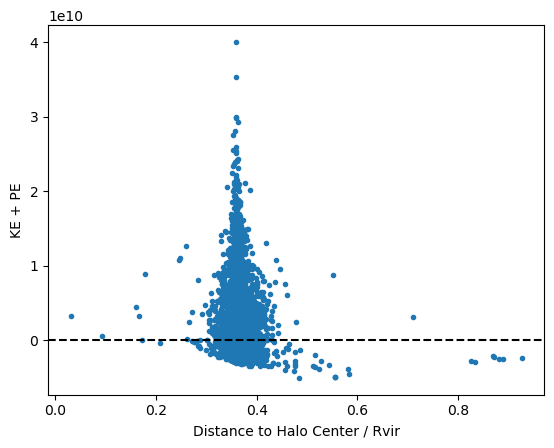

In [35]:
#sns.kdeplot(x = halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), y = E_list, fill=True)
plt.plot(halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), E_list, '.')
plt.axhline(0, linestyle='--', color='black')
plt.ylabel('KE + PE')
plt.xlabel('Distance to Halo Center / Rvir')

Only 30% of the stars are bound, which is unlikely. The error may come from the fact that the center of the stellar population is significantly off from the halo center, this introduces errors in the energy calculation. 

Suggestion from Kirk: subtract 

Use peak to determine the group of 

### Star Assignment Technique from AGORA Paper V and VII

Because SHINBAD output doesn't store the maximum circular velocity, we need to estimate it from the circular velocity at the virial radius

In [2]:
def weighted_std(values, weights_list):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights_list)
    N = len(values)
    # Fast and numerically precise:
    variance = np.sum(weights_list*(values-average)**2)/((N-1)*np.sum(weights_list)/N)
    return np.sqrt(variance)

In [3]:
def star_assignment(tree, branch, idx, pfs, sigma_cut = 2, distance_cut = 2):
    ds = yt.load(pfs[int(idx)])
    #
    branch = '0_4'
    halo_center = tree[branch][int(idx)]['Halo_Center']
    halo_rvir = tree[branch][int(idx)]['Halo_Radius']
    halo_mass = tree[branch][int(idx)]['Halo_Mass']
    halo_vel = tree[branch][int(idx)]['Vel_Com']
    halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v
    #
    halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
    halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
    vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir
    #

In [17]:
idx = '194'
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
ds = yt.load(ray_pfs[int(idx)])

yt : [INFO     ] 2024-12-11 16:59:32,587 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2024-12-11 16:59:32,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-11 16:59:32,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-11 16:59:32,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-11 16:59:32,597 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-11 16:59:32,600 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2024-12-11 16:59:32,602 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-11 16:59:32,604 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: hubble_constant           = 0.679


In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [18]:
branch = '0'
halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
halo_rvir = ray_rawtree[branch][int(idx)]['Halo_Radius']
halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
halo_vel = ray_rawtree[branch][int(idx)]['Vel_Com']
halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v

halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir

In [19]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [20]:
#Identify all the stars within the halo region
inreg_bool = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_rvir
inreg_pos = ray_pos_all[inreg_bool]
inreg_r = np.linalg.norm(inreg_pos - halo_center, axis=1)
#
inreg_vel = ray_vel_all[inreg_bool]
inreg_relvel = inreg_vel - halo_vel
inreg_relvelmag = np.linalg.norm(inreg_relvel, axis=1)
#
inreg_ID = ray_ID_all[inreg_bool]
inreg_mass = ray_mass_all[inreg_bool]

In [21]:
sigma_cut = 2
distance_cut = 2

In [22]:
reduced_bool = np.logical_and(inreg_r < 0.8*halo_rvir, inreg_relvelmag < 4*vcir)
reduced_mass = inreg_mass[reduced_bool]
reduced_pos = inreg_pos[reduced_bool]
reduced_com = np.average(reduced_pos, weights=reduced_mass, axis=0)
#
reduced_vel = inreg_vel[reduced_bool]
reduced_relvel = reduced_vel - np.average(reduced_vel, weights=reduced_mass, axis=0)
reduced_relvelmag = np.linalg.norm(reduced_relvel, axis=1)
sigma_vel = weighted_std(reduced_relvelmag, weights_list=reduced_mass)
#
reduced_ID = inreg_ID[reduced_bool]

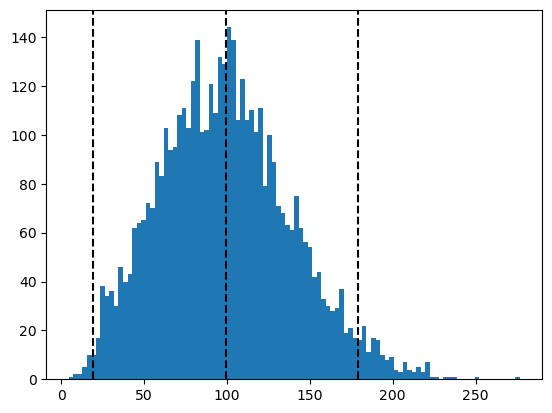

In [11]:
plt.hist(reduced_relvelmag, bins=100)
plt.axvline(np.average(reduced_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) - sigma_cut*sigma_vel, color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

In [23]:
def cal_R90(pos, center, mass):
    r = np.linalg.norm(pos - center, axis=1)
    r_sort = r[np.argsort(r)]
    mass_sort = mass[np.argsort(r)]
    mass_cumsum = np.cumsum(mass_sort)
    mass_cumsumpercent = mass_cumsum/mass_cumsum[-1]
    R90 = r_sort[np.where(mass_cumsumpercent > 0.9)[0][0]]
    return R90

In [24]:
r90_halocenter = cal_R90(reduced_pos, halo_center, reduced_mass)
r90_starcenter = cal_R90(reduced_pos, reduced_com, reduced_mass)

In [25]:
reduced2_bool = (np.linalg.norm(reduced_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                (np.linalg.norm(reduced_pos - reduced_com, axis=1) < distance_cut*r90_starcenter) & \
                (reduced_relvelmag <= np.average(reduced_relvelmag) + sigma_cut*sigma_vel)
reduced2_pos = reduced_pos[reduced2_bool]
reduced2_mass = reduced_mass[reduced2_bool]
reduced2_ID = reduced_ID[reduced2_bool]
reduced2_vel = reduced_vel[reduced2_bool]
reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)

In [26]:
counter = 0
while np.sum(reduced2_bool)/len(reduced2_bool) <= 0.99:
    if len(reduced2_pos) == 0:
        reduced2_com = np.nan
        break
    reduced2_relvel = reduced2_vel - np.average(reduced2_vel, weights=reduced2_mass, axis=0)
    reduced2_relvelmag = np.linalg.norm(reduced2_relvel, axis=1)
    #
    sigma_vel = weighted_std(reduced2_relvelmag, weights_list=reduced2_mass)
    r90_halocenter = cal_R90(reduced2_pos, halo_center, reduced2_mass)
    r90_starcenter = cal_R90(reduced2_pos, reduced2_com, reduced2_mass)
    #
    reduced2_bool = (np.linalg.norm(reduced2_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                    (np.linalg.norm(reduced2_pos - reduced2_com, axis=1) < distance_cut*r90_starcenter) & \
                    (reduced2_relvelmag <= np.average(reduced2_relvelmag) + sigma_cut*sigma_vel)
    reduced2_pos = reduced2_pos[reduced2_bool]
    reduced2_mass = reduced2_mass[reduced2_bool]
    reduced2_ID = reduced2_ID[reduced2_bool]
    reduced2_vel = reduced2_vel[reduced2_bool]
    reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)
    counter += 1
    print(counter)

1
2
3


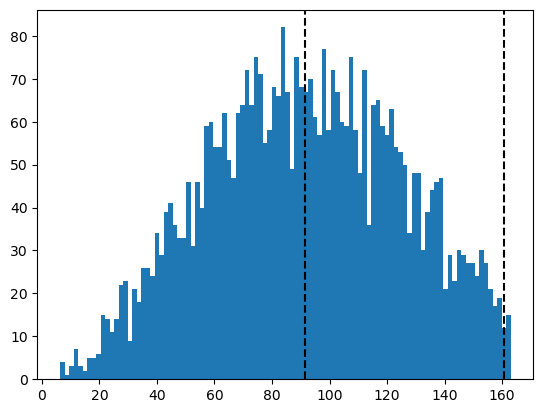

In [19]:
plt.hist(reduced2_relvelmag, bins=100)
plt.axvline(np.average(reduced2_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced2_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

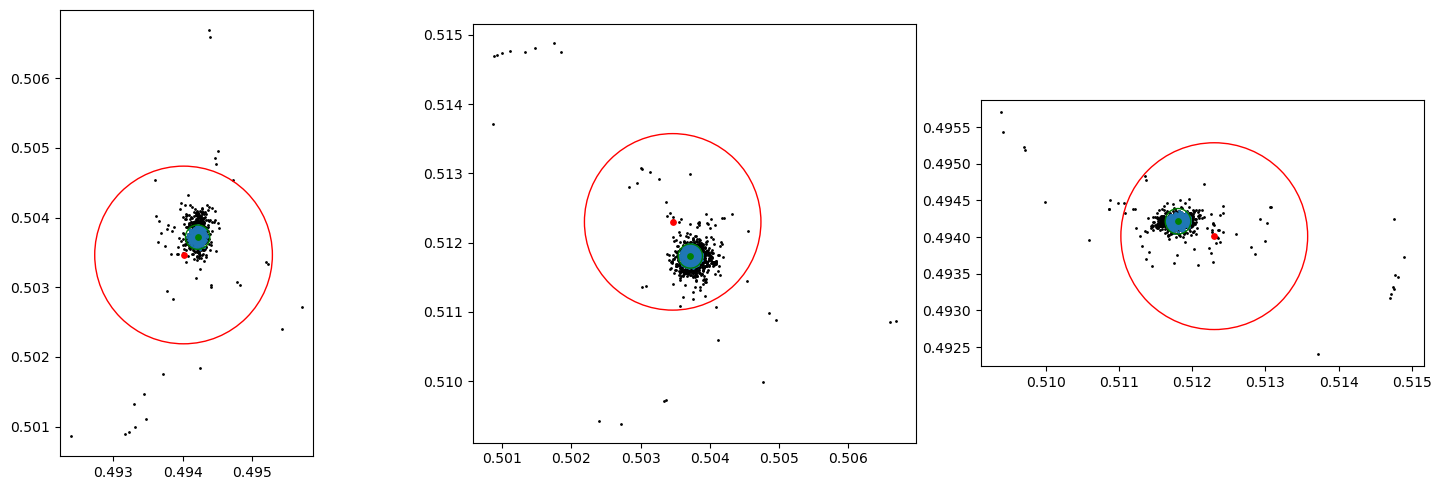

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axs[0].scatter(inreg_pos[:,0], inreg_pos[:,1], s=1, color='black')

axs[0].scatter(reduced2_pos[:,0], reduced2_pos[:,1], s=1)

axs[0].scatter(halo_center[0], halo_center[1], color='red', s=15)
circle1 = plt.Circle((halo_center[0], halo_center[1]), distance_cut*r90_halocenter, color='red', fill=False)
axs[0].add_patch(circle1)

axs[0].scatter(reduced2_com[0], reduced2_com[1], color='green', s=15)
circle2 = plt.Circle((reduced2_com[0], reduced2_com[1]), distance_cut*r90_starcenter, color='green', fill=False)
axs[0].add_patch(circle2)

axs[0].set_aspect('equal')

#---------------------------------------------------------
axs[1].scatter(inreg_pos[:,1], inreg_pos[:,2], s=1, color='black')

axs[1].scatter(reduced2_pos[:,1], reduced2_pos[:,2], s=1)

axs[1].scatter(halo_center[1], halo_center[2], color='red', s=15)
circle1 = plt.Circle((halo_center[1], halo_center[2]), distance_cut*r90_halocenter, color='red', fill=False)
axs[1].add_patch(circle1)

axs[1].scatter(reduced2_com[1], reduced2_com[2], color='green', s=15)
circle2 = plt.Circle((reduced2_com[1], reduced2_com[2]), distance_cut*r90_starcenter, color='green', fill=False)
axs[1].add_patch(circle2)

axs[1].set_aspect('equal')
#---------------------------------------------------------
axs[2].scatter(inreg_pos[:,2], inreg_pos[:,0], s=1, color='black')

axs[2].scatter(reduced2_pos[:,2], reduced2_pos[:,0], s=1)

axs[2].scatter(halo_center[2], halo_center[0], color='red', s=15)
circle1 = plt.Circle((halo_center[2], halo_center[0]), distance_cut*r90_halocenter, color='red', fill=False)
axs[2].add_patch(circle1)

axs[2].scatter(reduced2_com[2], reduced2_com[0], color='green', s=15)
circle2 = plt.Circle((reduced2_com[2], reduced2_com[0]), distance_cut*r90_starcenter, color='green', fill=False)
axs[2].add_patch(circle2)

axs[2].set_aspect('equal')

fig.tight_layout()